In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# 1.1. بارگذاری دیتاست
# این دیتاست رو می‌تونی از Kaggle دانلود کنی: "SMS Spam Collection Dataset"
# لینک: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
# فایل رو در کنار فایل Jupyter Notebook خودت قرار بده.
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
except FileNotFoundError:
    print("Error: spam.csv not found. Please download it from Kaggle and place it in the same directory.")
    print("Link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")
    exit() # خروج از برنامه اگر فایل پیدا نشد

# 1.2. بررسی دیتاست
print("Original DataFrame Head:")
print(df.head())

# دیتاست شامل ستون‌های اضافی است که نیازی به آن‌ها نداریم.
# ستون‌های 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' را حذف می‌کنیم.
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# تغییر نام ستون‌ها برای خوانایی بهتر
df.columns = ['label', 'text']

print("\nDataFrame Head after cleaning:")
print(df.head())

# 1.3. تبدیل برچسب‌ها (label) به مقادیر عددی
# 'ham' (غیر اسپم) را 0 و 'spam' (اسپم) را 1 در نظر می‌گیریم.
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("\nLabel distribution:")
print(df['label'].value_counts())

# 1.4. تقسیم داده‌ها به مجموعه آموزش و تست
# 80% برای آموزش و 20% برای تست
X = df['text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# 1.5. توکنایز کردن متن (Text Tokenization)
# تبدیل کلمات به اعداد (توکن‌ها)
# num_words: حداکثر تعداد کلماتی که در نظر گرفته می‌شوند (بر اساس فراوانی)
tokenizer = Tokenizer(num_words=10000, oov_token="<unk>") # <unk> برای کلمات ناشناخته
tokenizer.fit_on_texts(X_train) # توکنایزر را بر اساس متن‌های آموزشی فیت می‌کنیم

# تبدیل متن‌ها به دنباله‌ای از اعداد
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(f"\nExample of original text: {X_train[0]}")
print(f"Example of tokenized sequence: {X_train_sequences[0]}")

# 1.6. پدینگ دنباله‌ها (Padding Sequences)
# اطمینان از اینکه همه دنباله‌ها طول یکسانی دارند (برای ورودی شبکه عصبی)
# maxlen: حداکثر طول دنباله. دنباله‌های کوتاه‌تر با صفر پر می‌شوند و بلندترها کوتاه می‌شوند.
MAX_LEN = 100 # حداکثر طول پیامک (می‌توانید این را بر اساس طول پیامک‌های خود تنظیم کنید)

X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nExample of padded sequence: {X_train_padded[0]}")
print(f"Shape of X_train_padded: {X_train_padded.shape}")
print(f"Shape of X_test_padded: {X_test_padded.shape}")

Original DataFrame Head:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

DataFrame Head after cleaning:
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives a

In [2]:
# 2.1. تعریف پارامترهای مدل
VOCAB_SIZE = 10000 # تعداد کلمات منحصر به فرد در واژه‌نامه (همان num_words در Tokenizer)
EMBEDDING_DIM = 16 # ابعاد بردار برای هر کلمه (می‌توانید این را تغییر دهید)

# 2.2. ساخت مدل Sequential
model = keras.Sequential([
    # لایه Embedding: هر توکن عددی را به یک بردار متراکم (dense vector) تبدیل می‌کند.
    # این بردارها معنی کلمات را در خود جای می‌دهند.
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    
    # GlobalAveragePooling1D: میانگین بردارهای کلمات را در طول دنباله می‌گیرد.
    # این کار خروجی لایه Embedding را به یک بردار ثابت تبدیل می‌کند که می‌تواند به لایه‌های Dense داده شود.
    keras.layers.GlobalAveragePooling1D(),
    
    # لایه Dense پنهان (اختیاری، برای پیچیدگی بیشتر)
    keras.layers.Dense(24, activation='relu'),
    
    # لایه خروجی: 1 نورون با تابع فعال‌سازی Sigmoid
    # Sigmoid برای مسائل دسته‌بندی باینری (دو کلاسه) استفاده می‌شود.
    # خروجی بین 0 و 1 است که نشان‌دهنده احتمال اسپم بودن پیام است.
    keras.layers.Dense(1, activation='sigmoid')
])

# 2.3. نمایش خلاصه مدل
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [3]:
# کامپایل کردن مدل
model.compile(optimizer='adam',
              # تابع خطا: BinaryCrossentropy
              # مناسب برای مسائل دسته‌بندی باینری (دو کلاسه)
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [5]:
# آموزش مدل
EPOCHS = 15 # می‌توانید این عدد را برای دقت بیشتر تغییر دهید

history = model.fit(X_train_padded, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test_padded, y_test),
                    verbose=1) # verbose=1 
# فرض می‌کنیم مدل شما به نام 'model' هست و آموزش داده شده است.

# مسیر و نام فایل برای ذخیره مدل
model_path = 'my_spam_detection_model.h5' # میتونی اسمش رو عوض کنی

# ذخیره مدل
model.save(model_path)

print(f"Model saved successfully to {model_path}")


Epoch 1/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0617 - val_accuracy: 0.9839
Epoch 2/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0653 - val_accuracy: 0.9830
Epoch 3/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0677 - val_accuracy: 0.9830
Epoch 4/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0612 - val_accuracy: 0.9830
Epoch 5/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0662 - val_accuracy: 0.9830
Epoch 6/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0652 - val_accuracy: 0.9830
Epoch 7/15
140/140 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0690 - val_accuracy: 0.9830
Epoch 

35/35 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9839

Final Test Loss: 0.0890
Final Test Accuracy: 0.9839


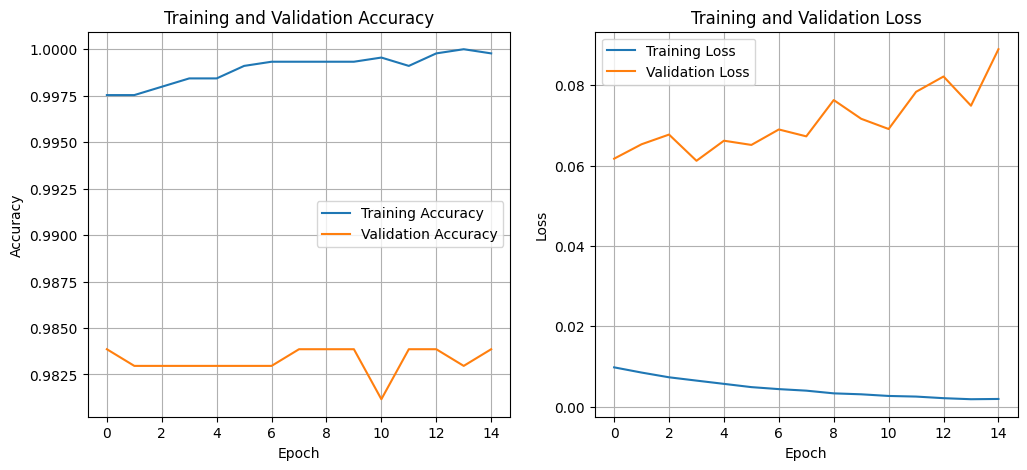

Model saved successfully to my_spam_detection_model.h5


In [6]:
# ارزیابی مدل روی داده‌های تست نهایی
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"\nFinal Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

# رسم نمودار دقت و خطا در طول آموزش
plt.figure(figsize=(12, 5))

# نمودار دقت
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# نمودار خطا
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# 5.1. ذخیره مدل آموزش‌دیده
model_path = 'my_spam_detection_model.h5'
model.save(model_path)
print(f"Model saved successfully to {model_path}")

In [11]:
# 6.1. بارگذاری مدل (اگر در یک جلسه جدید هستید)
# from tensorflow import keras
# model = keras.models.load_model('my_spam_detection_model.h5')

# 6.2. پیام‌های جدید برای تست
new_messages = [
    "Congratulations! You've won a free iPhone! Click here to claim.",
    "Hey, how are you doing today?",
    "URGENT! Your bank account has been compromised. Verify your details now: http://malicious.link",
    "Meeting at 3 PM tomorrow.",
    "Free entry to a prize draw! Text WIN to 80088 now!",
    "Hi, just checking in. Are you free this weekend?"
]

# 6.3. پیش‌پردازش پیام‌های جدید (همانند داده‌های آموزشی)
# تبدیل متن به دنباله اعداد
new_sequences = tokenizer.texts_to_sequences(new_messages)

# پدینگ دنباله‌ها
new_padded = pad_sequences(new_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 6.4. پیش‌بینی با مدل
predictions = model.predict(new_padded)

# 6.5. نمایش نتایج
print("\nSpam Detection Results:")
for i, message in enumerate(new_messages):
    probability = predictions[i][0] # احتمال اسپم بودن
    if probability > 0.5: # آستانه 0.5 برای تصمیم‌گیری
        prediction_label = "SPAM"
        color_code = "\033[91m" # کد رنگ قرمز برای اسپم
    else:
        prediction_label = "HAM"
        color_code = "\033[92m" # کد رنگ سبز برای غیر اسپم
    
    # خط پرینت اصلی که باید اصلاح شود
    # به جای قرار دادن بک‌اسلش‌ها در f-string، رشته‌ها را با عملگر + به هم می‌چسبانیم.
    # به کاراکتر '\n' (خط جدید) هم دقت کنید که چطور مدیریت شده است.
    print(color_code + "Message: '" + message + "'\n  -> Predicted: " + prediction_label + f" (Probability: {probability:.4f})" + "\033[0m")

1/1 [==============================] - 0s 126ms/step

Spam Detection Results:
Message: 'Congratulations! You've won a free iPhone! Click here to claim.'
  -> Predicted: SPAM (Probability: 0.7537)
Message: 'Hey, how are you doing today?'
  -> Predicted: HAM (Probability: 0.0001)
Message: 'URGENT! Your bank account has been compromised. Verify your details now: http://malicious.link'
  -> Predicted: SPAM (Probability: 0.9756)
Message: 'Meeting at 3 PM tomorrow.'
  -> Predicted: HAM (Probability: 0.0001)
Message: 'Free entry to a prize draw! Text WIN to 80088 now!'
  -> Predicted: SPAM (Probability: 0.9934)
Message: 'Hi, just checking in. Are you free this weekend?'
  -> Predicted: HAM (Probability: 0.0015)
